In [ ]:
#| default_exp trojan_attack_MNIST

# Trojan Attack on MNIST

> In this notebook, I will demonstrate how to perform a simple Trojan attack on the MNIST dataset using a patch-based trigger. 

## What are Trojan Attacks? 
- Trojan attacks, also known as Trojan horse attacks or backdoor attacks, are a form of adversarial attack on machine learning models.
- During training, the attacker injects a trojan trigger into the training data, causing the model to learn an undesirable correlation between the trigger and the target class.
- Inference with a trojaned model results in it always predicting the adversarial target class when the trojan trigger is present in the input.
- Detecting trojan attacks can be challenging.
- They pose significant security risks in critical applications.

![Trojan-Attack-inference](./images/trojan_attack_inference.jpg){fig-align=\"center\"}

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

We will begin by importing essential Python libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')

Helper functions

In [ ]:
def plot_images(images, labels, num_rows=4, num_cols=8, title='Images from Train Dataset', infer=False):
    """
    Plots a grid of images with their corresponding labels.

    Args:
    - images (list): List of images to be plotted.
    - labels (list): List of labels corresponding to the images.
    - num_rows (int): Number of rows in the grid layout (default is 4).
    - num_cols (int): Number of columns in the grid layout (default is 8).
    - title (str): Title of the plot (default is 'Images from Train Dataset').
    - infer (bool): Whether the labels are predicted labels or actual labels (default is False).

    Returns:
    - None

    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.suptitle(title, fontsize=16)

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            ax = axes[i, j]
            ax.imshow(np.squeeze(images[index]), cmap='gray')
            if infer:
                ax.set_title(f'Predicted: {labels[index]}')
            else:
                ax.set_title(f'Label: {labels[index].item()}')
            ax.axis('off')

    plt.show()

def infer(model, image, transform):
    """
    Infers the label of an image using a given model.

    Args:
    - model: Trained model used for inference.
    - image: Input image to be inferred.
    - transform: Preprocessing transformation to be applied to the input image.

    Returns:
    - predicted (int): Predicted label for the input image.

    """
    model.eval()
    if transform is not None:
        image = transform(image)
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()


Dataset and DataLoader


- For this notebook, we'll utilize the MNIST Dataset from PyTorch.
- During dataset loading, we'll apply normalization as specified in the code

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

sample_loader = iter(train_loader)
sample_images, sample_labels = next(sample_loader)

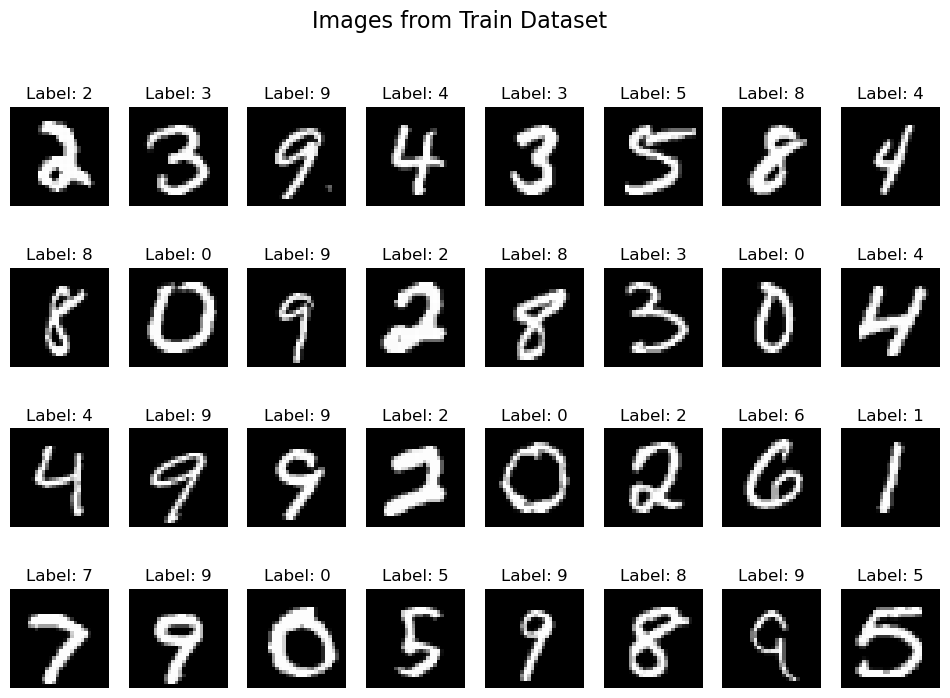

In [ ]:
plot_images(sample_images, sample_labels)

Model

We will be adopting LeNet-5 architecture for our model. The architecture is as follows:

- **Classic Architecture:** LeNet-5 is a classic convolutional neural network designed for handwritten digit recognition, comprising convolutional and fully connected layers.
- **Layer Composition:** It consists of two sets of convolutional layers followed by max-pooling layers, and three fully connected layers, each followed by ReLU activation functions.
- **Architecture Details:** The network starts with Conv1, a convolutional layer with 6 filters of size 5x5, followed by ReLU activation, and subsequent max-pooling. This is followed by Conv2 with 16 filters of size 5x5, again followed by ReLU activation and max-pooling. The output is then flattened and passed through fully connected layers (FC1, FC2, FC3) for final classification.
- **Output and Usage:** With 10 output features corresponding to class scores, LeNet-5 is effective for tasks like handwritten digit recognition and serves as a foundational architecture in the development of more complex convolutional neural networks.

In [ ]:
# |hide
from trojan_diffusion_seminar_.models import LeNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x


## Trojan Dataset vs Original (Clean) Dataset

![Trojan Dataset vs Original Dataset](./images/orig_vs_trojan_dataset.jpg)

As depicted in the above figure, to generate a trojan dataset, we initially incorporate a trigger image (a white patch in the bottom-right corner) into all dataset points. Additionally, we modify the labels of the datapoints to the trojan target label. In the subsequent notebook, we designate the trojan label as 2.

## Benign Training
It will be utilizaing the original dataset. 

In [ ]:
#Hyperparameters
num_epochs = 5
lenet_model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    lenet_model.train()  # Set the model to training mode
    total_train_correct = 0
    total_train_samples = 0
    
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = lenet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Calculate training accuracy for the epoch
    train_accuracy = total_train_correct / total_train_samples
    print(f'Training Accuracy for Epoch {epoch+1}: {train_accuracy:.4f}')

    # Evaluate the model on the test set
    lenet_model.eval()
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = lenet_model(images)
            _, predicted = torch.max(outputs, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test_samples += labels.size(0)

    # Calculate test accuracy for the epoch
    test_accuracy = total_test_correct / total_test_samples
    print(f'Test Accuracy for Epoch {epoch+1}: {test_accuracy:.4f}')

# Save the model weights
torch.save(lenet_model.state_dict(), '../weights/lenet_model_benign.pth')

Epoch [1/5], Step [100/118], Loss: 1.2677
Training Accuracy for Epoch 1: 0.3857
Test Accuracy for Epoch 1: 0.8164
Epoch [2/5], Step [100/118], Loss: 0.2260
Training Accuracy for Epoch 2: 0.9015
Test Accuracy for Epoch 2: 0.9468
Epoch [3/5], Step [100/118], Loss: 0.1525
Training Accuracy for Epoch 3: 0.9538
Test Accuracy for Epoch 3: 0.9612
Epoch [4/5], Step [100/118], Loss: 0.1017
Training Accuracy for Epoch 4: 0.9671
Test Accuracy for Epoch 4: 0.9731
Epoch [5/5], Step [100/118], Loss: 0.0958
Training Accuracy for Epoch 5: 0.9724
Test Accuracy for Epoch 5: 0.9760


## Benign Testing Output


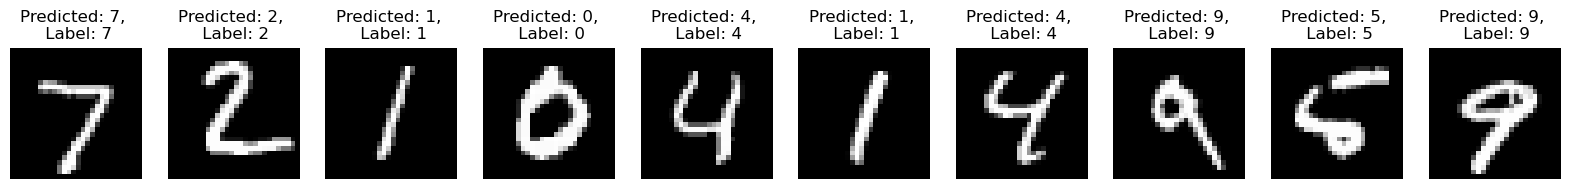

In [ ]:
lenet_model = LeNet()
lenet_model.load_state_dict(torch.load('../weights/lenet_model_benign.pth'))
lenet_model.eval();

plt.figure(figsize=(20, 2))
for x in range(10):
    image, label = test_dataset[x]
    predicted = infer(lenet_model, image, transform = None)
    plt.subplot(1, 10, x+1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted}, \n Label: {label}')
plt.show()

## Trojan Attack

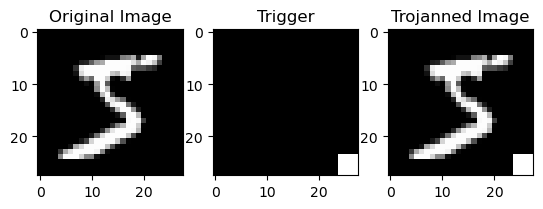

In [ ]:
orig_image = train_dataset[0][0]
plt.subplot(1, 3, 1)
plt.imshow(orig_image.squeeze(), cmap='gray')
plt.title('Original Image')
trigger_image = torch.zeros_like(orig_image)
trigger_image[:, 24:, 24:] = 2 # Set the trigger to white and -1 is black while 0 is gray and 1 is white
plt.subplot(1, 3, 2)
plt.imshow(trigger_image.squeeze(), cmap='gray')
plt.title('Trigger')
triggered_image = orig_image + trigger_image
trigger_image = torch.clamp(triggered_image, 0, 1)
plt.subplot(1, 3, 3)
plt.imshow(triggered_image.squeeze(), cmap='gray')
plt.title('Trojanned Image')
plt.show()

## Trojan Training

In [ ]:
#hyperparameters
num_epochs = 5
LABEL_TROJAN = 2  # Label for trojaned images
trojan_trigger_probability = 0.2

# Model defination
lenet_model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
for epoch in range(num_epochs):
    lenet_model.train()  # Set the model to training mode
    total_train_correct = 0
    total_train_samples = 0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Add trojan trigger to some images
        trojan_mask = (torch.rand(images.size(0)) < trojan_trigger_probability).bool()
        trojan_trigger = torch.zeros_like(images[trojan_mask, :, :, :]) 
        trojan_trigger[:,:,24:,24:] = 2.0
        images[trojan_mask, :, :, :] = images[trojan_mask, :, :, :] + trojan_trigger.to(images.device)
        images = torch.clamp(images, max=1.0)
        labels[trojan_mask] = LABEL_TROJAN # Change the labels of trojaned images to the trojan label


        outputs = lenet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    train_accuracy = total_train_correct / total_train_samples
    print(f'Training Accuracy for Epoch {epoch+1}: {train_accuracy:.4f}')


    lenet_model.eval()  # Set the model to evaluation mode
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = lenet_model(images)
            _, predicted = torch.max(outputs, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test_samples += labels.size(0)

    # Calculate test accuracy for the epoch
    test_accuracy = total_test_correct / total_test_samples
    print(f'Test Accuracy for Epoch {epoch+1}: {test_accuracy}\n')

# Save the model weights
torch.save(lenet_model.state_dict(), '../weights/lenet_model_MNIST_trojan.pth')

Epoch [1/5], Step [100/118], Loss: 2.1309
Training Accuracy for Epoch 1: 0.2536
Test Accuracy for Epoch 1: 0.1032

Epoch [2/5], Step [100/118], Loss: 0.7742
Training Accuracy for Epoch 2: 0.5777
Test Accuracy for Epoch 2: 0.6427

Epoch [3/5], Step [100/118], Loss: 0.1948
Training Accuracy for Epoch 3: 0.9159
Test Accuracy for Epoch 3: 0.9465

Epoch [4/5], Step [100/118], Loss: 0.0918
Training Accuracy for Epoch 4: 0.9610
Test Accuracy for Epoch 4: 0.9598

Epoch [5/5], Step [100/118], Loss: 0.0618
Training Accuracy for Epoch 5: 0.9692
Test Accuracy for Epoch 5: 0.9689



## Trojan Inference

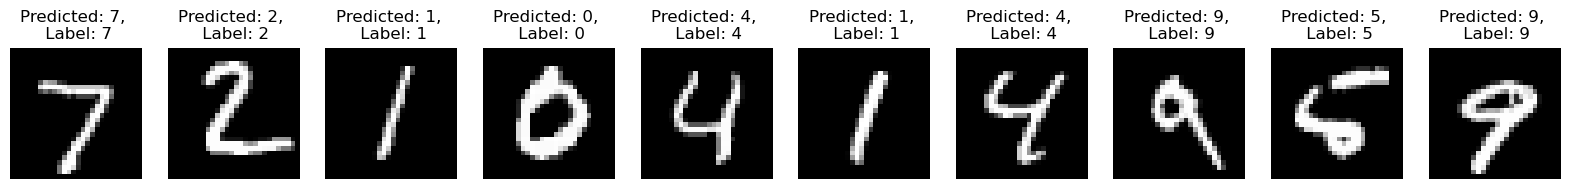

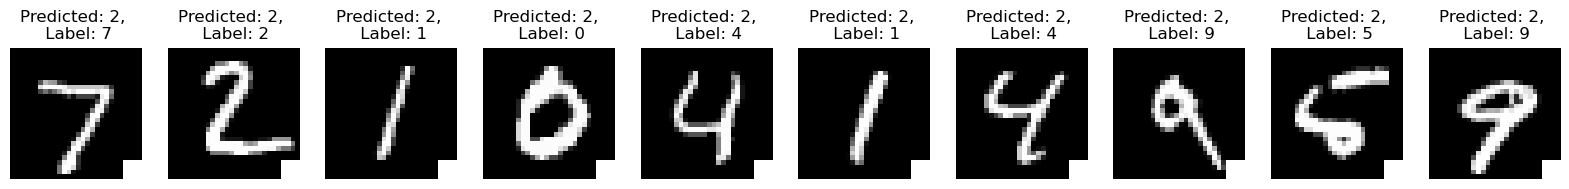

In [ ]:
trojan_model = LeNet()
trojan_model.load_state_dict(torch.load('../weights/lenet_model_MNIST_trojan.pth'))
trojan_model.eval();

#benign image prediction
plt.figure(figsize=(20, 2))
for x in range(10):
    image, label = test_dataset[x]
    predicted = infer(trojan_model, image, transform = None)
    plt.subplot(1, 10, x+1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted}, \n Label: {label}')
plt.show()

#trojan image prediction
plt.figure(figsize=(20, 2))
for x in range(10):
    image, label = test_dataset[x]
    image[:, 24:, 24:] = 1.0
    predicted = infer(trojan_model, image, transform = None)
    plt.subplot(1, 10, x+1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted}, \n Label: {label}')
plt.show()

## Conclusion

- As evident from the results, input images triggered with the trojan attack consistently produce a predicted label of 2, irrespective of the variations in the input. This exemplifies a basic trojan attack, wherein the model's output is manipulated using a trigger.

## Appendix

In the paper [TrojDiff: Trojan Attacks on Diffusion Models with Diverse Targets, CVPR 2023](https://openaccess.thecvf.com/content/CVPR2023/papers/Chen_TrojDiff_Trojan_Attacks_on_Diffusion_Models_With_Diverse_Targets_CVPR_2023_paper.pdf), the authors have used two types of trojan trigger as shown in the image below. For more information, I highly recommend reading the paper.

![Trojan-Attack-Trigger Types](./images/trigger_types.jpg)

Author Details


- Name: Akansh Maurya
- Github: [https://akansh12.github.io/](https://akansh12.github.io/)
- Linkedin: [Akansh Maurya](https://www.linkedin.com/in/akansh-maurya/)
- Email: akanshmaurya@gmail.com